<a href="https://colab.research.google.com/github/aydin-utting/MPhys_QML/blob/master/QNN_Fisher_Information.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib

In [ ]:
import torch                                                                
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


def jacobian(y, x, create_graph=False):                                                               
    jac = []                                                                                          
    flat_y = y.reshape(-1)                                                                            
    grad_y = torch.zeros_like(flat_y)                                                                 
    for i in range(len(flat_y)):                                                                      
        grad_y[i] = 1.                                                                                
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph)
        jac.append(grad_x.reshape(x.shape))                                                           
        grad_y[i] = 0.                                                                                
    return torch.stack(jac).reshape(y.shape + x.shape)                                                
                                                                                                      
def hessian(y, x):                                                                                    
    return jacobian(jacobian(y, x, create_graph=True), x)  

def fisher(y,x):
    j = jacobian(y, x, create_graph=True)
    return torch.outer(j,j)                                        

In [ ]:
n_samples = 100
X0 = torch.tensor(np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1),
                np.random.normal(loc=-1, scale=1),
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]),requires_grad=False)


X1 = torch.tensor(np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1),
                np.random.normal(loc=1, scale=1),
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]),requires_grad=False)

X = torch.cat((X0, X1),0)

Y = torch.cat((torch.tensor(np.array([[1,0] for i in range(n_samples//2)])), 
               torch.tensor(np.array([[0,1] for i in range(n_samples//2)]))), 0)

data = list(zip(X, Y))




def loss_single(prediction,label):
  delta = prediction-label
  return torch.dot(delta,delta)*1

def model(x,w):
  sig = nn.Sigmoid()
  softmax = nn.Softmax()

  layer_1 = torch.split(w,[16,24])
  w_1 = layer_1[0].reshape(4,4)
  x = sig(torch.matmul(x,w_1))

  layer_2 = torch.split(layer_1[1],[16,8])
  w_2 = layer_2[0].reshape(4,4)
  x = sig(torch.matmul(x,w_2))

  w_3 = layer_2[1].reshape(4,2)
  x = torch.matmul(x,w_3)
  f = x.copy()
  x = softmax(x)

  return f,x

def loss_avg(data,w):
  loss_tot = 0
  Fisher = torch.zeros((40,40))
  for x,y in data:
      prediction = model(x,w)
      loss_tot += loss_single(prediction[1],y)
      Fisher += fisher(loss_single(prediction[1],y),w)
      diag_pi = torch.diag(np.ones_like(w)*prediction[1])
      pipiT= torch.outer(np.ones_like(w)*prediction[1],np.ones_like(w)*prediction[1])
      jac = jacobian(prediction[0],w)
      print(jac)
      print(pipiT)
      print(diag_pi)
      print(torch.matmul(torch.matmul(jac,(diag_pi-pipiT),torch.transpose(jac))

  return loss_tot/n_samples,Fisher/n_samples

def normalise_fishers(Fishers):
    num_samples = len(Fishers)
    TrF_integral = (1 / num_samples) * np.sum(np.array([torch.trace(F) for F in Fishers]))
    return [((40) / TrF_integral) * F for F in Fishers]


n_iter = 100
all_fishers = torch.zeros((n_iter,40,40))
EVs = np.array([])
FR = []
Rank = []
for i in range(n_iter):
  w = torch.tensor(np.random.uniform(size=(40,),low=-1.0,high=1.0),requires_grad=True)
  total_loss, Fisher = loss_avg(data,w)
  all_fishers[i] = Fisher
  with torch.no_grad():
    Rank.append(torch.matrix_rank(Fisher).item())
    Fw = np.matmul(Fisher.numpy(),w.numpy())
    wFw = np.dot(w,Fw)
    FR.append(wFw)

normalised_fishers = normalise_fishers(all_fishers)

for F in normalised_fishers:
  EVs = np.append(EVs,torch.eig(F, eigenvectors=False,  out=None)[0][:,0].detach().numpy())
  #print(EVs)



print("Fisher")
x, bins, p=plt.hist(EVs, bins=5,rwidth=0.6,color='r',range=[0,4])
for item in p:
  item.set_height(item.get_height()/(40*n_iter))
plt.ylim(0,1)
plt.title("Classical NN - normalised")
plt.show()

plt.hist(Rank)
plt.title('matrix ranks for all Fisher')
plt.show()
plt.hist(FR)
plt.title('Fisher-Rao norm for all Fisher')
plt.show()

tensor([[ 0.0181,  0.0018,  0.0103,  ...,  0.0298, -0.0577,  0.0693],
        [ 0.0018,  0.0021,  0.0055,  ..., -0.0081, -0.0128,  0.0226],
        [ 0.0103,  0.0055, -0.0062,  ..., -0.1099,  0.0846, -0.1007],
        ...,
        [ 0.0298, -0.0081, -0.1099,  ..., -0.5202,  0.9951, -0.4345],
        [-0.0577, -0.0128,  0.0846,  ...,  0.9951,  0.1852,  0.9393],
        [ 0.0693,  0.0226, -0.1007,  ..., -0.4345,  0.9393, -0.3534]],
       dtype=torch.float64, grad_fn=<SubBackward0>)
tensor([[-4.7221e-02, -6.6579e-03, -9.2550e-04,  ..., -6.3094e-02,
          1.5614e-02, -8.1908e-02],
        [-6.6579e-03,  3.7497e-02,  1.7520e-03,  ..., -9.6799e-02,
          4.6208e-02, -1.0133e-01],
        [-9.2550e-04,  1.7520e-03,  1.4006e-02,  ...,  2.8013e-02,
          8.5916e-04,  1.6802e-02],
        ...,
        [-6.3094e-02, -9.6799e-02,  2.8013e-02,  ..., -1.0147e+00,
          2.7456e-01, -1.0217e+00],
        [ 1.5614e-02,  4.6208e-02,  8.5916e-04,  ...,  2.7456e-01,
          2.8105e-01, 

KeyboardInterrupt: ignored

In [ ]:
!pip install pennylane

     |████████████████████████████████| 409kB 7.4MB/s 
  Created wheel for pennylane: filename=PennyLane-0.14.1-cp37-none-any.whl size=481980 sha256=b44504ce62d99a8b69b745c70de29561e8f7c3e15ca8530d27b7c4e17dbc4d3e
  Stored in directory: /root/.cache/pip/wheels/6e/a9/c9/04941d6dd58b3c111cbd1389bf63ba1b23362c137359af4626
Successfully built pennylane


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import copy
import matplotlib.pyplot as plt

In [ ]:
n_samples = 100
variance = (np.pi/4)**2
X0 = np.array([[np.random.normal(loc=-np.pi/4, scale=variance), 
                np.random.normal(loc=np.pi/4, scale=variance),
                np.random.normal(loc=-np.pi/4, scale=variance),
                np.random.normal(loc=np.pi/4, scale=variance)] for i in range(int(n_samples/2))],requires_grad=False)


X1 = np.array([[np.random.normal(loc=np.pi/4, scale=variance), 
                np.random.normal(loc=-np.pi/4, scale=variance),
                np.random.normal(loc=np.pi/4, scale=variance),
                np.random.normal(loc=-np.pi/4, scale=variance)] for i in range(int(n_samples/2))],requires_grad=False)

X = np.append(X0, X1,0)

Y = np.append(np.array([0 for i in range(int(n_samples/2))],requires_grad=False),np.array([1 for i in range(int(n_samples/2))],requires_grad=False))

data = list(zip(X, Y))

In [ ]:
depth=15

dev = qml.device("default.qubit", wires=5)
@qml.qnode(dev, diff_method='backprop', wires=5)
def quantum_neural_network(x, w, depth):

    #encoding circuit============================================================

    #Hadamards
    for i in range(4):
        qml.Hadamard(wires=i)
        
    #Accounting for depth=0
    if(depth==0):
        for i in range(4):
            qml.RZ(x[i],wires=i)

    #Multiple encoding layers:
    for k in range(depth):
        #RZ gates
        for i in range(4):
            qml.RZ(x[i],wires=i)
        #RZZ gates
        for i in range(4):
            for j in range(i):
                qml.CNOT(wires=[j,i])
                qml.RZ(((x[i])*(x[j])),wires=[i])
                qml.CNOT(wires=[j,i])

        
    #variational circuit
    for j in range(9):
      for i in range(4):
          qml.RY(w[j][i],wires=i)
      qml.broadcast(qml.CNOT, wires=[0,1,2,3], pattern="all_to_all", parameters=None, kwargs=None)

    for i in range(4):
        qml.RY(w[9][i],wires=i)

    dev.shots = 1000
    
    for i in range(4):
      qml.CNOT(wires=[i,4])
    
    return qml.expval(qml.PauliZ(wires=4))


 
@qml.qnode(dev, diff_method='backprop', wires=5)
def easy_quantum(x, w):
  #encoding
    for i in range(4):
      qml.Hadamard(wires=[i])
      qml.RZ(x[i],wires=i)
    

    #variational circuit
    for j in range(9):
      for i in range(4):
          qml.RY(w[j][i],wires=i)
      qml.broadcast(qml.CNOT, wires=[0,1,2,3], pattern="all_to_all", parameters=None, kwargs=None)
    for i in range(4):
        qml.RY(w[9][i],wires=i)

    dev.shots = 1000
    for i in range(4):
      qml.CNOT(wires=[i,4])
    
    return qml.expval(qml.PauliZ(wires=4))


def get_parity_prediction(model, x,w):

    #choice of models
    if model=="QNN": np_measurements = (quantum_neural_network(x,w)+1.)/2.
    else: np_measurements= (easy_quantum(x,w)+1.)/2.
  
    return np.array([np_measurements,1.-np_measurements])

def single_loss(model, w,x,y):
    prediction = get_parity_prediction(model, x,w)
    return rel_ent(prediction, y)

def rel_ent(pred,y):
    return -np.log(pred)[int(y)]

def average_loss(w, data,model):
  c = 0
  Fisher = np.zeros((40,40))
  for i,(x, y) in enumerate(data):
    single_cost = single_loss(model,w,x,y)
    
    c += single_cost
    grad_fn = qml.grad(single_loss,argnum=1)
    gradient = grad_fn(model,w,x,y).flatten()
    Fisher += np.outer(gradient,gradient)
  
  return c/len(data),Fisher/len(data)

EVs = np.array([])
models=["QNN"]
n_iter=5
all_fishers = np.zeros((2,n_iter,40,40))
count = 0
for i in range(n_iter):
  print(i)
  for j, model in enumerate(models):
    w = np.array(np.split(np.random.uniform(size=(40,),low=-1.0,high=1.0),10),requires_grad=True)
    Fisher = average_loss(w,data,model)[1]
    all_fishers[j][i]=Fisher

def normalise_fishers(Fishers):
    num_samples = len(Fishers)
    TrF_integral = (1 / num_samples) * np.sum([np.trace(F) for F in Fishers])
    return [((40) / TrF_integral) * F for F in Fishers]


0
[[[ 5.90638025e-02  2.45610398e-02  5.84173259e-02  1.10941570e-01]
  [-3.21551138e-02  6.74661749e-02  5.24559679e-02 -1.03978967e-01]
  [ 4.05158882e-02  6.48490713e-02 -1.16242809e-01 -4.71392621e-02]
  [-9.65968048e-02 -4.11786255e-02  5.04265494e-02 -2.04032048e-02]
  [-5.53361586e-02  5.16904908e-02  4.89509375e-02  2.63897784e-02]
  [ 4.72206740e-02  1.21947335e-01 -6.19153100e-03 -2.98855656e-02]
  [-1.44259970e-02  4.28402062e-02 -2.62159224e-02 -3.92976980e-02]
  [ 4.85956741e-03 -1.60925319e-04 -4.09059439e-02 -8.12602989e-02]
  [-1.89757369e-02 -3.42398211e-02 -3.62464029e-02  6.16256577e-03]
  [-1.66033216e-01  1.22650844e-01 -8.46026933e-02  2.07999586e-02]]

 [[-5.90638025e-02 -2.45610398e-02 -5.84173259e-02 -1.10941570e-01]
  [ 3.21551138e-02 -6.74661749e-02 -5.24559679e-02  1.03978967e-01]
  [-4.05158882e-02 -6.48490713e-02  1.16242809e-01  4.71392621e-02]
  [ 9.65968048e-02  4.11786255e-02 -5.04265494e-02  2.04032048e-02]
  [ 5.53361586e-02 -5.16904908e-02 -4.895093

ValueError: ignored

In [ ]:
#all_fishers = np.load("fisher.npy")
def normalise_fishers(Fishers):
    num_samples = len(Fishers)
    TrF_integral = (1. / num_samples) * np.sum([np.trace(F) for F in Fishers])
    return [((40) / TrF_integral) * F for F in Fishers]

def get_entropy(x,length):
  entropy=0
  x = x/length
  for i in x:
    if(i!=0):
      entropy-=i*np.log(i)
  return entropy

normalised_fishers = normalise_fishers(all_fishers[0])
EVs = np.array([])
for F in normalised_fishers:
  val, v = np.linalg.eig(F)
  EVs = np.append(np.real(EVs),val)





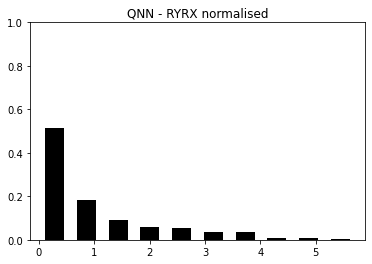

In [ ]:

#plot histogram
x, bins, p=plt.hist(EVs, bins=10,rwidth=0.6,color='black')

for item in p:
  item.set_height(item.get_height()/len(EVs)) # normalise it
plt.ylim(0,1)
plt.title("QNN - RYRX normalised")
plt.show()

In [ ]:
get_entropy(x,len(EVs))

1.552223372523677

Easy Quantum using backprop
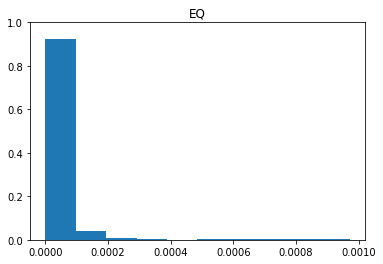



Easy Quantum using Parameter Shift
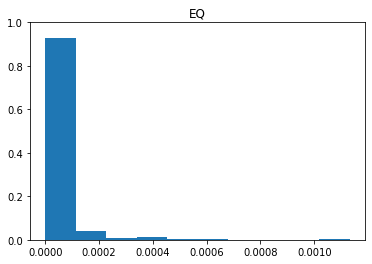

Text(0, 0.5, 'entropy (10 bins)')

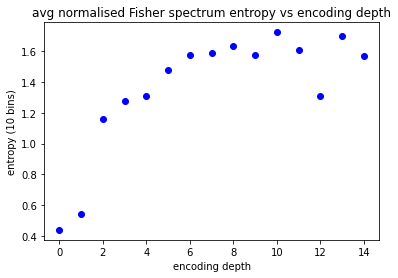

In [ ]:
entropies=np.array([0.439,0.545,1.162,1.274,1.307,1.476,1.572,1.588,1.633,1.572,1.723,1.606,1.309,1.697,1.566])
plt.plot(range(depth+1),entropies, 'bo')
plt.title("avg normalised Fisher spectrum entropy vs encoding depth")
plt.xlabel("encoding depth")
plt.ylabel("entropy (10 bins)")

In [ ]:
len(data)


100

In [ ]:
models[0]

'EQ'

In [ ]:
n_samples = 100
variance = 1
X0 =np.array([[np.random.normal(loc=-1, scale=variance), 
                np.random.normal(loc=1, scale=variance),
                np.random.normal(loc=-1, scale=variance),
                np.random.normal(loc=1, scale=variance)] for i in range(int(n_samples/2))],requires_grad=False)


X1 = np.array([[np.random.normal(loc=1, scale=variance), 
                np.random.normal(loc=-1, scale=variance),
                np.random.normal(loc=1, scale=variance),
                np.random.normal(loc=-1, scale=variance)] for i in range(int(n_samples/2))],requires_grad=False)

X = np.append(X0, X1,0)

Y = np.append(np.array([0 for i in range(int(n_samples/2))],requires_grad=False),np.array([1 for i in range(int(n_samples/2))],requires_grad=False))

data = list(zip(X, Y))

dev = qml.device("default.qubit", wires=4) 
@qml.qnode(dev, diff_method='parameter-shift')
def quantum_neural_network(x, w):
    qml.templates.IQPEmbedding(x, wires=[0,1,2,3], n_repeats=2, pattern=None)
    for j in range(10):
      for i in range(4):
        qml.RY(w[j][i],wires=i) 
      qml.broadcast(qml.CNOT, wires=[0,1,2,3], pattern="all_to_all", parameters=None, kwargs=None)
    dev.shots = 1000
    sample_measurements = [qml.sample(qml.PauliZ(wires=i)) for i in range(4)]
    return sample_measurements


dev = qml.device("default.qubit", wires=4) 
@qml.qnode(dev, diff_method='backprop')
def easy_quantum(x, w):
    qml.templates.IQPEmbedding(x, wires=[0,1,2,3], n_repeats=2, pattern=None)

    for j in range(10):
      for i in range(4):
        qml.RY(w[j][i],wires=[i]) 
    dev.shots = 1000
    sample_measurements = [qml.sample(qml.PauliZ(wires=i)) for i in range(4)]
    return sample_measurements


def get_parity_prediction(model, x,w):

    #choice of models
    if model=="QNN": np_measurements = (quantum_neural_network(x,w)+1.)/2.
    else: np_measurements= (easy_quantum(x,w)+1.)/2.
    p_1 = (1.-np_measurements).prod() + np_measurements.prod()
    #get parity
    for i in range(4):
        for j in range(i):
            a = np.zeros((4))
            a[i] = 1
            a[j] = 1
            p_1 += (a-np_measurements).prod()
    return np.array([p_1,1.-p_1])

def rel_ent(pred,y):
    return -1.*np.log(pred)[int(y)]

def single_loss(model, w,x,y):
    prediction = get_parity_prediction(model, x,w)
    return rel_ent(prediction, y)


#initialise weights
w = np.array(np.split(np.random.uniform(size=(40,),low=-1.0,high=1.0),10),requires_grad=True)




EVs = np.array([])
model = "QNN" # "QNN" or "EQ"

shift = np.pi/2
n_iter=1
#for i in range(n_iter):
  #initialise weights randomly
#print(i)
w = np.array(np.split(np.random.uniform(size=(40,),low=-1.0,high=1.0),10),requires_grad=True)
Fisher = average_loss(w,data,shift,model)[1]
#find eigenvalues and add to the list
val, v = np.linalg.eig(Fisher)
EVs =np.append(EVs,np.real(val))

#plot histogram
x, bins, p=plt.hist(EVs, bins=None,range=None)
for item in p:
  item.set_height(item.get_height()/(40*n_iter)) # normalise it
plt.ylim(0,1)
plt.title(model)
plt.show()
print(quantum_neural_network.draw())

TypeError: ignored

In [ ]:
a = np.array([1.+0.2j, 2.+1j])
print(a)
print(np.real(a))

[1.+0.2j 2.+1.j ]
[1. 2.]


In [ ]:




import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn import preprocessing

#Torch for Classical NN
import torch
import torch.nn as nn
import torch.nn.functional as F


#PennyLane for QNN
import pennylane as qml
from pennylane.optimize import AdamOptimizer


    
# load IRIS dataset
dataset = pd.read_csv('iris.csv')


# transform species to numerics
dataset.loc[dataset.species=='Iris-setosa', 'species'] = 0
dataset.loc[dataset.species=='Iris-versicolor', 'species'] = 2
dataset.loc[dataset.species=='Iris-virginica', 'species'] = 1
dataset = dataset.query('species==0 or species==1')
print(dataset.query('species==0 or species==1'))
x = dataset.loc[0:,dataset.columns[0:4]].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled,columns=dataset.columns[0:4])


print(df)

#normalise
train_X, train_Y = df.astype(float).values, dataset.species.astype(int).values
print(train_Y)

from pennylane import numpy as np
train_X = np.array(train_X,requires_grad=False)
train_Y = np.array(train_Y,requires_grad=False)

data = list(zip(train_X,train_Y))
dev = qml.device("default.qubit", wires=5) 


#QUANTUM NEURAL NETWORK
@qml.qnode(dev, diff_method='backprop')
def quantum_neural_network(x, w):

    #encoding
    for i in range(4):
        qml.Hadamard(wires=i)
        qml.RZ(x[i],wires=i)

    for i in range(4):
        for j in range(i):
            qml.CNOT(wires=[j,i])
            qml.RZ(((np.pi-x[i])*(np.pi-x[j])),wires=[i])
            qml.CNOT(wires=[j,i])

    for i in range(4):
        qml.RZ(x[i],wires=i)

    for i in range(4):
        for j in range(i):
            qml.CNOT(wires=[j,i])
            qml.RZ(((np.pi-x[i])*(np.pi-x[j])),wires=[i])
            qml.CNOT(wires=[j,i])


    #variational
    for i in range(4):
        qml.RY(w[0][i],wires=i)

    qml.broadcast(qml.CNOT, wires=[0,1,2,3], pattern="all_to_all", parameters=None, kwargs=None)

    for i in range(4):
        qml.RY(w[1][i],wires=i)

    dev.shots = 10000

    for i in range(4):
      qml.CNOT(wires=[i,4])

    return qml.expval(qml.PauliZ(wires=4))

w = np.array(np.split(np.random.uniform(size=(8,),low=-1,high=1),2),requires_grad=True)
print(quantum_neural_network(train_X[0],w))
print(quantum_neural_network.draw())
print(dataset)

     sepal_length  sepal_width  petal_length  petal_width species
0             5.1          3.5           1.4          0.2       0
1             4.9          3.0           1.4          0.2       0
2             4.7          3.2           1.3          0.2       0
3             4.6          3.1           1.5          0.2       0
4             5.0          3.6           1.4          0.2       0
..            ...          ...           ...          ...     ...
145           6.7          3.0           5.2          2.3       1
146           6.3          2.5           5.0          1.9       1
147           6.5          3.0           5.2          2.0       1
148           6.2          3.4           5.4          2.3       1
149           5.9          3.0           5.1          1.8       1

[100 rows x 5 columns]
    sepal_length  sepal_width  petal_length  petal_width
0      -0.555556     0.181818     -0.864407    -0.916667
1      -0.666667    -0.272727     -0.864407    -0.916667
2      -0.777

In [ ]:
def initialise_data():
    n_samples = 100
    variance = (np.pi/4)**2
    X0 = np.array([[np.random.normal(loc=-np.pi/4, scale=variance), 
                    np.random.normal(loc=np.pi/4, scale=variance),
                    np.random.normal(loc=-np.pi/4, scale=variance),
                    np.random.normal(loc=np.pi/4, scale=variance)] for i in range(int(n_samples/2))],requires_grad=False)


    X1 = np.array([[np.random.normal(loc=np.pi/4, scale=variance), 
                    np.random.normal(loc=-np.pi/4, scale=variance),
                    np.random.normal(loc=np.pi/4, scale=variance),
                    np.random.normal(loc=-np.pi/4, scale=variance)] for i in range(int(n_samples/2))],requires_grad=False)

    X = np.append(X0, X1,0)

    Y = np.append(np.array([0 for i in range(int(n_samples/2))],requires_grad=False),np.array([1 for i in range(int(n_samples/2))],requires_grad=False))

    data = list(zip(X, Y))

    return data



dev = qml.device("default.qubit", wires=5)
@qml.qnode(dev, diff_method='backprop', wires=5)
def quantum_neural_network(x, w,depth):

    #encoding circuit============================================================

    #Hadamards
    for i in range(4):
        qml.Hadamard(wires=i)
        
    #Accounting for depth=0
    if(depth==0):
        for i in range(4):
            qml.RZ(x[i],wires=i)

    #Multiple encoding layers:
    for k in range(depth):
        #RZ gates
        for i in range(4):
            qml.RZ(x[i],wires=i)
        #RZZ gates
        for i in range(4):
            for j in range(i):
                qml.CNOT(wires=[j,i])
                qml.RZ(((x[i])*(x[j])),wires=[i])
                qml.CNOT(wires=[j,i])

        
    #variational circuit
    for j in range(9):
      for i in range(4):
          qml.RY(w[j][i],wires=i)
      qml.broadcast(qml.CNOT, wires=[0,1,2,3], pattern="all_to_all", parameters=None, kwargs=None)

    for i in range(4):
        qml.RY(w[9][i],wires=i)

    dev.shots = 1000
    
    for i in range(4):
      qml.CNOT(wires=[i,4])
    
    return qml.expval(qml.PauliZ(wires=4))

def get_parity_prediction(x,w,depth):
    np_measurements = (quantum_neural_network(x,w,depth)+1.)/2.
  
    return np.array([np_measurements,1.-np_measurements])

def single_loss(w,x,y,depth):
    prediction = get_parity_prediction(x,w,depth)
    return rel_ent(prediction, y)

def rel_ent(pred,y):
    return -np.log(pred)[int(y)]

def average_loss(w, data,depth):
  c = 0
  Fisher = np.zeros((40,40))
  for i,(x, y) in enumerate(data):
    single_cost = single_loss(w,x,y,depth)
    
    c += single_cost
    #print(single_cost)
    grad_fn = qml.grad(single_loss,argnum=0)
    gradient = grad_fn(w,x,y,depth).flatten()
    #print(gradient)
    #gradient = gradient/np.linalg.norm(gradient)
    Fisher += np.outer(gradient,gradient)
  
  return c/len(data),Fisher/len(data)


n_iter=5

def get_all_fishers(n_iter,depth):
  all_fishers = np.zeros((n_iter,40,40))
  count = 0
  data = initialise_data()
  for i in range(n_iter):
    w = np.array(np.split(np.random.uniform(size=(40,),low=-1.0,high=1.0),10),requires_grad=True)
    Fisher = average_loss(w,data,depth)[1]
    all_fishers[i]=Fisher
  return all_fishers

def normalise_fishers(Fishers):
    num_samples = len(Fishers)
    TrF_integral = (1 / num_samples) * np.sum([np.trace(F) for F in Fishers])
    return [((40) / TrF_integral) * F for F in Fishers]


def get_entropy(depth,n_iter=5,bins=10):
  all_fishers = get_all_fishers(n_iter,depth)
  normalised_fishers = normalise_fishers(all_fishers)
  EVs = np.array([])
  for F in normalised_fishers:
    val, v = np.linalg.eig(F)
    EVs = np.append(np.real(EVs),val)
  x, bins, p=plt.hist(EVs, bins=bins)
  entropy=0
  x = x/len(EVs)
  for i in x:
    if(i!=0):
      entropy-=i*np.log(i)
  return entropy



depth:  0  iteration:  0
depth:  0  iteration:  1
depth:  0  iteration:  2
depth:  1  iteration:  0
depth:  1  iteration:  1
depth:  1  iteration:  2
depth:  2  iteration:  0
depth:  2  iteration:  1
depth:  2  iteration:  2
depth:  3  iteration:  0
depth:  3  iteration:  1
depth:  3  iteration:  2
depth:  4  iteration:  0
depth:  4  iteration:  1
depth:  4  iteration:  2
depth:  5  iteration:  0
depth:  5  iteration:  1
depth:  5  iteration:  2
depth:  6  iteration:  0
depth:  6  iteration:  1
depth:  6  iteration:  2
depth:  7  iteration:  0
depth:  7  iteration:  1
depth:  7  iteration:  2
depth:  8  iteration:  0
depth:  8  iteration:  1
depth:  8  iteration:  2
depth:  9  iteration:  0
depth:  9  iteration:  1
depth:  9  iteration:  2
depth:  10  iteration:  0
depth:  10  iteration:  1
depth:  10  iteration:  2
depth:  11  iteration:  0
depth:  11  iteration:  1
depth:  11  iteration:  2
depth:  12  iteration:  0
depth:  12  iteration:  1
depth:  12  iteration:  2
depth:  13  iter

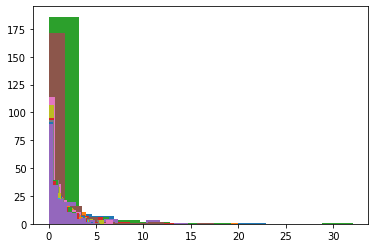

In [ ]:
std_rounds = 3
depths = 15
depth_entropies = np.zeros((depths,std_rounds))
for depth in range(depths):
  for j in range(std_rounds):
    print("depth: ",depth, " iteration: ",j)
    depth_entropies[depth][j] = get_entropy(depth,n_iter=5)



In [ ]:
depth_entropies_RX = np.load("/content/depth_entropies_RYRX.npy")
depth_entropies_RY = np.load("/content/depth_entropies.npy")

In [ ]:
mean_entropies_RX, std_entropies_RX = np.mean(depth_entropies_RX,axis=1),np.std(depth_entropies_RX,axis=1)
mean_entropies_RY, std_entropies_RY = np.mean(depth_entropies_RY,axis=1),np.std(depth_entropies_RY,axis=1)

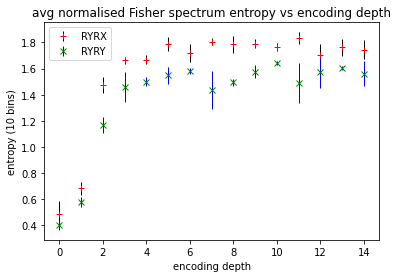

In [ ]:
plt.errorbar(x=range(depths),y=mean_entropies_RX,yerr=std_entropies_RX,color='red',marker='+',ls=" ",elinewidth=1,ecolor='black',label="RYRX")
plt.errorbar(x=range(depths),y=mean_entropies_RY,yerr=std_entropies_RY,color='green',marker='x',ls=" ",elinewidth=1,ecolor='blue',label="RYRY")
plt.title("avg normalised Fisher spectrum entropy vs encoding depth")
plt.xlabel("encoding depth")
plt.ylabel("entropy (10 bins)")
plt.legend()
plt.show()

In [ ]:
#SAME AS ABOVE W/ 8 TRAINABLE PARAMS
def initialise_data():
    n_samples = 100
    variance = (np.pi/4)**2
    X0 = np.array([[np.random.normal(loc=-np.pi/4, scale=variance), 
                    np.random.normal(loc=np.pi/4, scale=variance),
                    np.random.normal(loc=-np.pi/4, scale=variance),
                    np.random.normal(loc=np.pi/4, scale=variance)] for i in range(int(n_samples/2))],requires_grad=False)


    X1 = np.array([[np.random.normal(loc=np.pi/4, scale=variance), 
                    np.random.normal(loc=-np.pi/4, scale=variance),
                    np.random.normal(loc=np.pi/4, scale=variance),
                    np.random.normal(loc=-np.pi/4, scale=variance)] for i in range(int(n_samples/2))],requires_grad=False)

    X = np.append(X0, X1,0)

    Y = np.append(np.array([0 for i in range(int(n_samples/2))],requires_grad=False),np.array([1 for i in range(int(n_samples/2))],requires_grad=False))

    data = list(zip(X, Y))

    return data



dev = qml.device("default.qubit", wires=5)
@qml.qnode(dev, diff_method='backprop', wires=5)
def quantum_neural_network(x, w,depth):

    #encoding circuit============================================================

    #Hadamards
    for i in range(4):
        qml.Hadamard(wires=i)
        
    #Accounting for depth=0
    if(depth==0):
        for i in range(4):
            qml.RZ(x[i],wires=i)

    #Multiple encoding layers:
    for k in range(depth):
        #RZ gates
        for i in range(4):
            qml.RZ(x[i],wires=i)
        #RZZ gates
        for i in range(4):
            for j in range(i):
                qml.CNOT(wires=[j,i])
                qml.RZ(((x[i])*(x[j])),wires=[i])
                qml.CNOT(wires=[j,i])

        
    #variational circuit
    for j in range(4):
        qml.RY(w[0][j],wires=i)
    qml.broadcast(qml.CNOT, wires=[0,1,2,3], pattern="all_to_all", parameters=None, kwargs=None)

    for i in range(4):
        qml.RY(w[1][i],wires=i)

    dev.shots = 1000
    
    for i in range(4):
      qml.CNOT(wires=[i,4])
    
    return qml.expval(qml.PauliZ(wires=4))

def get_parity_prediction(x,w,depth):
    np_measurements = (quantum_neural_network(x,w,depth)+1.)/2.
  
    return np.array([np_measurements,1.-np_measurements])

def single_loss(w,x,y,depth):
    prediction = get_parity_prediction(x,w,depth)
    return rel_ent(prediction, y)

def rel_ent(pred,y):
    return -np.log(pred)[int(y)]

def average_loss(w, data,depth):
  c = 0
  Fisher = np.zeros((40,40))
  for i,(x, y) in enumerate(data):
    single_cost = single_loss(w,x,y,depth)
    
    c += single_cost
    #print(single_cost)
    grad_fn = qml.grad(single_loss,argnum=0)
    gradient = grad_fn(w,x,y,depth).flatten()
    #print(gradient)
    #gradient = gradient/np.linalg.norm(gradient)
    Fisher += np.outer(gradient,gradient)
  
  return c/len(data),Fisher/len(data)


n_iter=5

def get_all_fishers(n_iter,depth):
  all_fishers = np.zeros((n_iter,40,40))
  count = 0
  data = initialise_data()
  for i in range(n_iter):
    w = np.array(np.split(np.random.uniform(size=(8,),low=-1.0,high=1.0),2),requires_grad=True)
    Fisher = average_loss(w,data,depth)[1]
    all_fishers[i]=Fisher
  return all_fishers

def normalise_fishers(Fishers):
    num_samples = len(Fishers)
    TrF_integral = (1 / num_samples) * np.sum([np.trace(F) for F in Fishers])
    return [((40) / TrF_integral) * F for F in Fishers]


def get_entropy(depth,n_iter=5,bins=10):
  all_fishers = get_all_fishers(n_iter,depth)
  normalised_fishers = normalise_fishers(all_fishers)
  EVs = np.array([])
  for F in normalised_fishers:
    val, v = np.linalg.eig(F)
    EVs = np.append(np.real(EVs),val)
  x, bins, p=plt.hist(EVs, bins=bins)
  entropy=0
  x = x/len(EVs)
  for i in x:
    if(i!=0):
      entropy-=i*np.log(i)
  return entropy

